# Part I 머신러닝
# chapter 2 머신러닝 프로젝트 처음부터 끝까지

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

#데이터를 추출하는 함수
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [2]:
#판다스를 사용하여 데이터 읽기
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info() #전체 정보 null값 여부, 총 데이터 개수

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts() #ocean_proximity 값이 실수가 아니라서 무슨 값이 있는지 보기

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


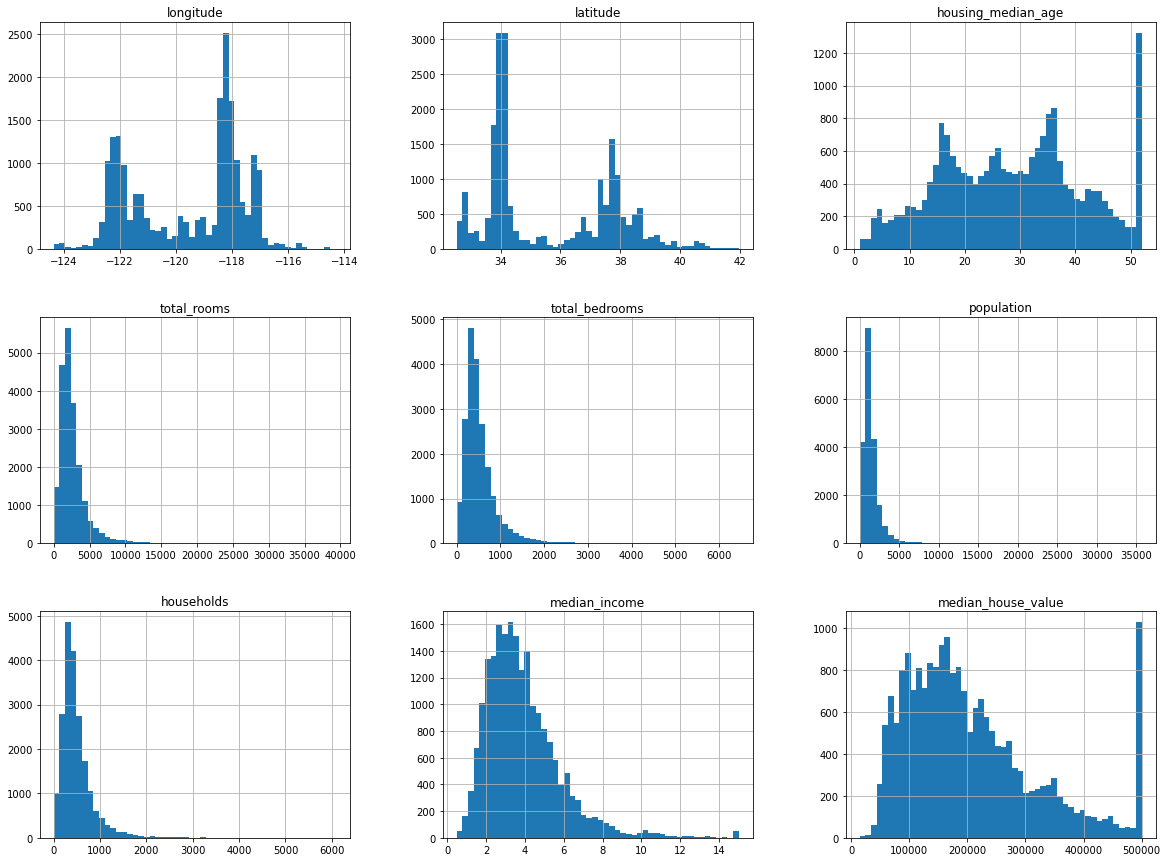

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
#테스트 세트만들기(무작위로 어떤 샘플을 선택해서 데이터셋의 20%정도, 또는 데이터셋이 매우크다면 그보다 작게, 떼어내기)
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [10]:
#데이터셋 업데이트 이후에도 테스트 세트가 동일하게 유지되게 하기
#새 샘플의 20%를 갖게 되지만 이전에 훈련세트에 있던 샘플은 포함 시키지 않음
from zlib import crc32

def test_set_check(idenfifier, test_ratio):
    return crc32(np.int64(idenfifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
#행의 인덱스를 ID로 사용하기
housing_with_id = housing.reset_index() #index열이 추가된 데이터프레임 반환

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
#고유식별자를 만들기 위한 과정
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
#사이킷런으로 데이터셋을 여러 서브셋으로 나누기
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
#random_state -> 난수 초깃값을 지정하는 매개변수

<AxesSubplot:>

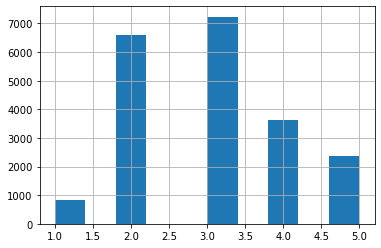

In [14]:
#pd.cut() 함수를 사용 하여 카테고리를 나누기, 소득분위에 따른 계층의 중요도를 측정하기 위해
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6.,np.inf], labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [15]:
#사이킷런의 Stratified ShuffleSplit을 사용하여 계층 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
#데이터셋에 있는 소득 카테고리의 비율 측정
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [17]:
#데이터를 원래 상태로 돌리기
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

In [18]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

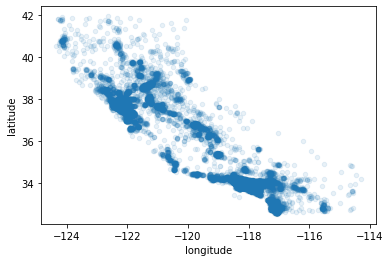

In [19]:
housing.plot(kind = "scatter", x="longitude", y="latitude", alpha = 0.1)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

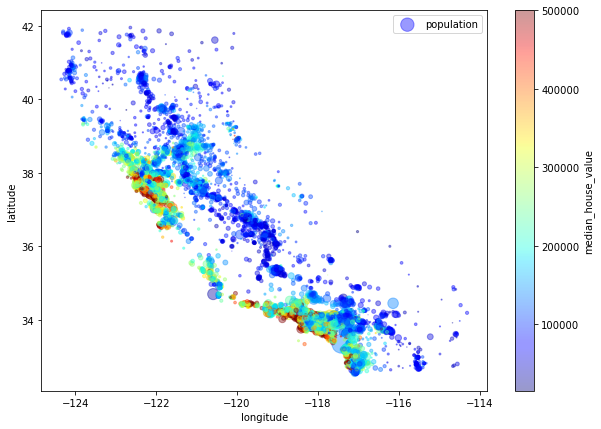

In [20]:
housing.plot(kind = "scatter", x="longitude", y="latitude", alpha = 0.4,
            s = housing["population"]/100, label = "population", figsize=(10,7),
            c="median_house_value", cmap = plt.get_cmap("jet"), colorbar=True, sharex=False)

In [21]:
corr_matrix = housing.corr() #표준 상관계수(피어슨의 r)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

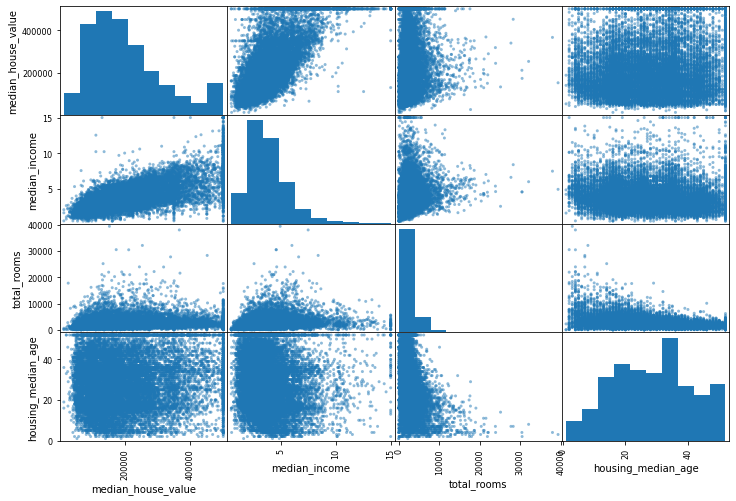

In [23]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

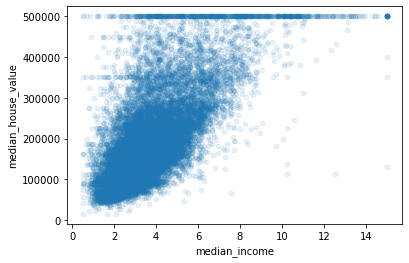

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha =0.1)

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [26]:
corr_matix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [27]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [28]:
#누락된 값을 중간 값으로 대체하는 함수 만들기
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [29]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [30]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [31]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [32]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [33]:
X = imputer.transform(housing_num)

In [34]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [35]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [36]:
#텍스트를 숫자로 바꾸기
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [37]:
ordinal_encoder.categories_

#총 다섯개라서 0~4의 수로 변환

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [38]:
# 한특성만 1이고 나머지는 0으로 바꾸는 원-핫 인코딩
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [39]:
housing_cat_1hot.toarray()  # 0과 1로 바뀐 모습이다

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [40]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X,rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [42]:
#연속된 변환을 순서대로 처리할 수 있도록 도와주는 Pipeline클래스
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_sclar', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [43]:
#주책 가격 데이터에 전체 변환
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [44]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [45]:
#선형 회귀분석
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [46]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("예측 : ",lin_reg.predict(some_data_prepared))
print("레이블 : ",list(some_labels))

예측 :  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
레이블 :  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [47]:
#회귀 모델의 RMSE측정, 오차측정
from sklearn.metrics import mean_squared_error
housing_predicitions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predicitions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [48]:
#강력하고 데이터에서 복잡한 비선형 관계를 찾을수 있는 모델
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [49]:
#훈련세트로 평가
housing_predicitions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predicitions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

오차가 0 이면 완벽한 모델이기 보다는 너무 심하게 과대 적합된 것으로 보인다

In [50]:
#사이킷런의 k-겹 교차검증
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [51]:
def display_scores(scores):
    print("점수 : ",scores)
    print("평균 : ",scores.mean())
    print("표준편차 : ", scores.std())

display_scores(tree_rmse_scores)

점수 :  [72737.35575809 71401.48138764 68154.74927857 71594.33778636
 70471.79935762 76806.49452609 73525.99657475 72663.68049135
 67278.09959562 70790.04117141]
평균 :  71542.40359275043
표준편차 :  2563.703497589334


In [52]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수 :  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균 :  69104.07998247063
표준편차 :  2880.3282098180657


In [53]:
#특성을 무작위로 선택해서 많은 결정트리를 만들고 그 예측을 평균내는 방식의 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [54]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18648.19737091866

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [56]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [57]:
#최적의 추정기에 직접 접근하기
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [59]:
#각 특성의 상대적인 중요도
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [60]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold","bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204355, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887772, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

In [61]:
#테스트 세트에서 최종 모델 평가
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [62]:
#일반화 오차의 95%신뢰구간 계산
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

# 연습문제

1. 서포트벡터머신회귀(sklearn.svm.SVR)를 kernael="linear"(하이퍼파라미터 C를 바꿔가며)나 kernal="rbf"(하이퍼파라미터 C와 gamma를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로시도해보세요. 지금은 이 하이퍼 파라미터가 무엇을 의미하는지 너무 신경쓰지마세요. 최상의 SVR모델은 무엇인가요?

In [64]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kernel': ['linear'], 'C':[10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1.0,3.0]}
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=  10.1s
[CV] END ..............................C=10.0, kernel=linear; total time=  10.4s
[CV] END ..............................C=10.0, kernel=linear; total time=  10.3s
[CV] END ..............................C=10.0, kernel=linear; total time=  10.4s
[CV] END ..............................C=10.0, kernel=linear; total time=  11.0s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.2s
[CV] END ..............................C=30.0, kernel=linear; total time=  14.2s
[CV] END ..............................C=30.0, kernel=linear; total time=  14.1s
[CV] END ..............................C=30.0, kernel=linear; total time=  15.3s
[CV] END ..............................C=30.0, kernel=linear; total time=  12.6s
[CV] END .............................C=100.0, kernel=linear; total time=  11.5s
[CV] END .............................C=100.0, 

[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  19.6s
[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  20.2s
[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  19.7s
[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  20.4s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  19.7s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  19.6s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  21.2s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  22.4s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  20.6s
[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=  19.9s
[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=  20.5s
[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=  20.1s
[CV] END ...................

[CV] END .....................C=300.0, gamma=0.1, kernel=rbf; total time=  19.5s
[CV] END .....................C=300.0, gamma=0.1, kernel=rbf; total time=  19.1s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  19.0s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  19.3s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  18.6s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  18.6s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  18.6s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  18.6s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  18.5s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  18.6s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  18.5s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  18.6s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [65]:
#최상 모델의(5-폴드 교차 검증으로 평가한) 점수는 다음과 같다.
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70286.61836530612

In [66]:
#최상의 하이퍼파라미터 확인
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

2. GridSearchCV를 RandomizedSerachCV로 바꿔보세요

In [63]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# expon(), reciprocal()와 그외 다른 확률 분포 함수에 대해서는
# https://docs.scipy.org/doc/scipy/reference/stats.html를 참고하세요.

# 노트: kernel 매개변수가 "linear"일 때는 gamma가 무시됩니다.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=  11.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   9.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   9.1s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   9.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.9s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  18.3s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  18.1s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  18.6s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  19.9s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  19.1s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  20.5s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  18.8s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  19.0s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=  10.6s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=  10.3s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=  10.2s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=  10.3s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=  10.6s
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 3.1min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 3.0min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 3.2min
[CV] END C=151136.2028

[CV] END C=60.17373642891687, gamma=1.2491263443165994, kernel=linear; total time=  10.5s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  19.3s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  19.5s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  19.5s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  19.1s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  19.0s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=  10.8s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=  10.6s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=  10.4s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=  11.6s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=  11.2s
[CV] END C=55.538389

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EFCFCD8B20>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EFCF308AC0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [64]:
# 최상 모델의 점수
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54751.69009256622

In [65]:
#최상의 하이퍼 파라미터
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

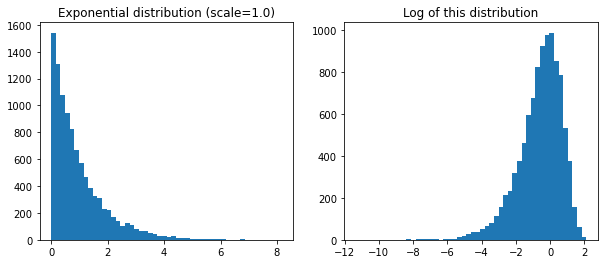

In [66]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

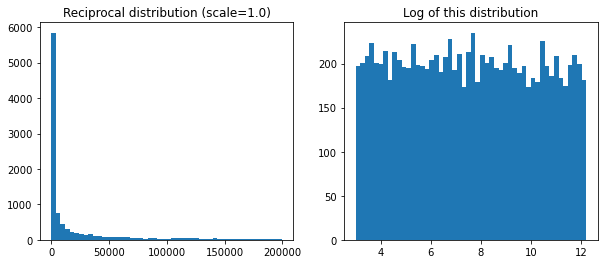

In [67]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

3. 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

노트 : 이 특성 선택 클래스는 이미 어떤 식으로든 특성 중요도를 계산했다고 가정합니다. TopFeatureSelector의 fit()메서드에서 직접 계산할 수도 있지만(캐싱을 사용하지 않을 경우) 그리드서치나 랜덤서치의 모든 하이퍼 파라미터 조합에 대해 계산이 일어나기 때문에 매우 느려집니다.

In [69]:
# 최상의 k개 특성의 인덱스 확인
k = 5

In [70]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12], dtype=int64)

In [71]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [72]:
# 재확인
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204355, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude')]

In [73]:
# 준비 파이프라인과 특성 선택기를 추가한새로운 파이프라인 만들기
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [74]:

housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [75]:
#처음 3개 샘플의 특성 확인
housing_prepared_top_k_features[0:3]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

In [76]:
#최상의 k개의 특성 확인
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

4. 전체 데이터 준비 과정과 최종 예측을 하나의 파이프 라인으로 만들어 보세요.

In [77]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [78]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_sclar',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                     

In [79]:
# 몇 개의 샘플에 전체 파이프라인 적용
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 83384.49158095 299407.90439234  92272.03345143 150173.16199041]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


5. GridSearchCV를 사용해 준비 단계의 옵션을 자동으로 탐색해 보세요

In [80]:
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  13.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  20.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  19.2s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  19.1s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  19.0s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  13.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  19.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  18.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  19.1s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  19.1s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  13.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  18.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  18.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  19.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  19.2s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  13.5s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  20.5s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  19.4s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  19.3s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  19.3s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  13.5s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  20.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  19.3s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  19.8s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  19.2s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  13.6s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  19.5s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  19.4s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  19.7s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  19.5s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  13.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  19.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  19.3s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  19.0s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  19.2s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  13.4s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  19.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  19.3s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  19.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  19.4s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  13.4s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  19.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  19.0s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  19.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  19.2s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  13.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  19.1s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  19.3s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  19.3s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  19.2s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  13.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  21.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  22.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  20.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  19.3s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  13.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  19.2s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  19.3s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  19.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  19.2s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  14.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  21.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  20.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  20.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  21.5s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  14.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  20.2s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  20.9s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  24.4s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  20.8s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  14.4s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  20.2s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  20.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  20.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  20.3s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  14.5s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  20.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  21.8s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  20.8s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  20.7s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  15.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  20.0s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  20.5s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  20.6s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  20.6s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  14.5s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  20.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  20.6s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  19.9s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  24.4s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  18.6s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  27.0s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  24.2s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  24.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  24.3s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  15.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  21.5s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  21.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  21.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  20.9s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  15.0s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  20.6s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  20.3s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  21.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  21.6s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  19.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  22.2s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  22.6s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  22.6s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  23.4s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  18.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  22.5s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  23.8s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  23.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  23.4s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  17.5s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  22.2s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  22.8s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  26.2s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  26.6s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  23.9s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  29.9s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  28.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  28.4s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  28.0s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  21.8s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  28.7s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  28.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  27.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  30.4s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  19.5s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  30.3s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  29.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  27.1s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  30.2s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  31.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  33.4s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  32.2s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  35.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  30.8s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  26.0s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  33.9s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  32.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  35.2s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  33.8s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  29.4s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  34.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  35.8s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  36.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  33.4s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  27.7s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  41.5s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  36.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  37.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  32.7s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  25.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  33.3s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  31.0s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  39.4s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  33.6s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  36.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  39.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  42.3s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  44.5s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  43.6s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  28.5s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  38.9s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  39.1s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  38.0s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  35.5s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  38.3s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  39.0s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  33.2s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  32.0s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  38.5s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  33.3s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  36.4s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  41.7s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  34.4s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  39.4s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  34.3s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  36.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  38.6s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  42.4s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  34.4s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  33.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  40.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  34.3s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  40.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  39.9s


C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Annaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Annaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Annaconda3\lib\site-packages\sklearn\p

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  33.1s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  35.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  41.1s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  36.6s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  35.4s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=   0.0s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  37.0s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  40.3s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  39.9s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  41.3s
[CV] 

C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Annaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Annaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Annaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Annaconda3\lib\site-packages\joblib\memory.py", line 349, in __c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_sclar',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
        

In [81]:
grid_search_prep.best_params_

{'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'mean'}

최상의 Imputer 정책은 most_frequent이고 거의 모든 특성이 유용합니다.(16개 중 15개)

마지막 특성(island)은 잡음이 추가될 뿐입니다.